# The simplest adversarial attack: attacking a linear model
Author: Pierre Ablin

Highly inspired by "Megyeri, Hegedus and Jelasity, *Adversarial robustness of linear models: regularization and dimensionality*, Esann 2019". 


In this notebook, we show the simplest form of adversarial attack: an attack of a linear model for binary classification.

We are going to use the famous MNIST dataset containing digits, and try to discriminate 3's from 7's.

Given some training samples $(x_1, y_1), \cdots, (x_n, y_n)$ with $x_i \in \mathbb{R}^{p}$ and $y_i = \pm 1$, the linear model builds a decision function based on a hyperplane:

$$ y = \text{sign}(w^{\top}x + b) \enspace, $$

where $w \in \mathbb{R}^p$ and $b\in \mathbb{R}$ is the intercept. The algorithm learns $w$ and $b$ from the training samples.

In the following, we use a regularized logistic regression.


<img src="
https://pierreablingithub.files.wordpress.com/2019/04/fig.png" align="center" hspace="10px" vspace="0px">


## Preprocessing

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

First, fetch the MNIST dataset:

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

We are only interested in samples which are 3's or 7's:

In [3]:
idxs = (y == '3') + (y == '7')
y = y[idxs]
X = X[idxs]

Permute the dataset, split it into train and test, and apply a scaling preprocessing.

In [4]:
random_state = np.random.RandomState(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, train_size=12000, test_size=2000,
                   random_state=random_state)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Fitting the linear model

We fit a logistic regression on the training data

In [5]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

We can compute the score on the test data:

In [6]:
print('test score = {}'.format(logreg.score(X_test, y_test)))

test score = 0.9895


That is very high, clearly the hyperplane separates well the two classes.

## Adversarial attack

Let's take a training sample for x:

In [7]:
x = X_train[0]

In [8]:
def show(x):
    plt.title('Prediction: %s. Confidence: %d %%' %
              (logreg.predict([x])[0],
               100 * logreg.predict_proba([x]).max()),
              fontsize=18)
    plt.imshow(scaler.inverse_transform(x).reshape(28, 28),
               cmap=plt.cm.gray_r, vmin=0, vmax=255)
    plt.axis('off')

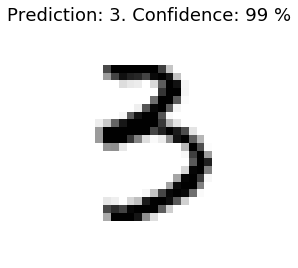

In [9]:
show(x)

The decision algorithm is **very** confident that this is a 3.

Remember that the decision function is defined with a hyperplane $w^{\top}x + b$.
Thus, taking a certain x, we can move it in the hyperplane by doing:
$$ x_1 =  x - \frac{w^{\top}x + b}{w^{\top}w}w$$ 


In [10]:
w = logreg.coef_[0]
b = logreg.intercept_

x1 = x - (np.dot(w, x) + b) / np.dot(w, w) * w

Doing so, the algorithm predicts with equal probability the two classes:

In [11]:
logreg.predict_proba([x1])

array([[0.5, 0.5]])

What does the new x look like?

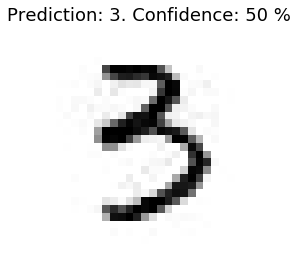

In [12]:
show(x1)

Still looks like a 3 !

And we can take things further by moving x on the other side of the hyperplane:

$$ x_2 =  x - \alpha \frac{w^{\top}x + b}{w^{\top}w}w \enspace, $$ 
where $\alpha > 1$:

In [13]:
perturbation = 1.3 * (np.dot(w, x) + b) / np.dot(w, w) * w
x2 = x - perturbation

In [14]:
logreg.predict_proba([x2])

array([[0.0011772, 0.9988228]])

Now, the algorithm is quite confident that it is a 7!

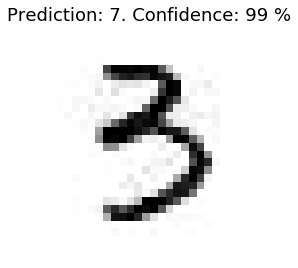

In [15]:
show(x2)

It still perfectly looks like a 3 to a human. This is what is called an *adversarial attack*: a small perturbation of x completely confuses the classification algorithm. Note that the adversarial perturbation is small compared to x:

In [16]:
np.linalg.norm(perturbation) / np.linalg.norm(x)

0.16364926107662514

<img src="
https://pierreablingithub.files.wordpress.com/2019/04/fig2.png" align="center" hspace="10px" vspace="0px">

The essence of adversarial attack is that even though $x_2$ belongs to 'the other side' of the hyperplane, it is still a '3' according to our own human classifier.

This simple experiment shows that adversarial attacks are possible for one of the simplest classification model. Intuitively, increasing the model complexity, for instance by using a neural network, further worsen the problem.